In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

In [69]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [70]:
data = pd.read_csv(r'C:\Users\p\Downloads\train_train.csv')

In [71]:
import datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

data['year'] = data['timestamp'].dt.year
data['month'] = data['timestamp'].dt.month
data['day'] = data['timestamp'].dt.day
data['dayofweek'] = data['timestamp'].dt.dayofweek

data

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day,dayofweek
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,1
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,2,2
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,3,3
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,4,4
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,5,5
...,...,...,...,...,...,...,...,...,...,...,...
43948,RD_F_J_20220127,2022-01-27,RD,F,J,522900.0,536.0,2022,1,27,3
43949,RD_F_J_20220128,2022-01-28,RD,F,J,435800.0,588.0,2022,1,28,4
43950,RD_F_J_20220129,2022-01-29,RD,F,J,422700.0,623.0,2022,1,29,5
43951,RD_F_J_20220130,2022-01-30,RD,F,J,484440.0,481.0,2022,1,30,6


In [72]:
encoding_columns = ['item','corporation', 'location']
not_encoding_columns = ['ID', 'timestamp', 'supply(kg)', 'price(원/kg)', 'year', 'month', 'day', 'dayofweek']

In [73]:
# 범주형 데이터 변환

enc_classes = {}

def encoding_labels(x):
    le = LabelEncoder()
    label = le.fit_transform(x)
    enc_classes[x.name] = le.classes_
    return label

In [74]:
d1 = data[encoding_columns].apply(encoding_labels)
d1.head()

,item,corporation,location
0,4,0,0
1,4,0,0
2,4,0,0
3,4,0,0
4,4,0,0


In [75]:
d2 = data[not_encoding_columns]
d2.head()

,ID,timestamp,supply(kg),price(원/kg),year,month,day,dayofweek
0,TG_A_J_20190101,2019-01-01,0.0,0.0,2019,1,1,1
1,TG_A_J_20190102,2019-01-02,0.0,0.0,2019,1,2,2
2,TG_A_J_20190103,2019-01-03,60601.0,1728.0,2019,1,3,3
3,TG_A_J_20190104,2019-01-04,25000.0,1408.0,2019,1,4,4
4,TG_A_J_20190105,2019-01-05,32352.0,1250.0,2019,1,5,5


In [76]:
data = d1.join(d2)
data

,item,corporation,location,ID,timestamp,supply(kg),price(원/kg),year,month,day,dayofweek
0,4,0,0,TG_A_J_20190101,2019-01-01,0.0,0.0,2019,1,1,1
1,4,0,0,TG_A_J_20190102,2019-01-02,0.0,0.0,2019,1,2,2
2,4,0,0,TG_A_J_20190103,2019-01-03,60601.0,1728.0,2019,1,3,3
3,4,0,0,TG_A_J_20190104,2019-01-04,25000.0,1408.0,2019,1,4,4
4,4,0,0,TG_A_J_20190105,2019-01-05,32352.0,1250.0,2019,1,5,5
...,...,...,...,...,...,...,...,...,...,...,...
43948,3,5,0,RD_F_J_20220127,2022-01-27,522900.0,536.0,2022,1,27,3
43949,3,5,0,RD_F_J_20220128,2022-01-28,435800.0,588.0,2022,1,28,4
43950,3,5,0,RD_F_J_20220129,2022-01-29,422700.0,623.0,2022,1,29,5
43951,3,5,0,RD_F_J_20220130,2022-01-30,484440.0,481.0,2022,1,30,6


In [99]:
# Feature와 Target 데이터셋 분리
X = data[['item','corporation','location','year','month','day','dayofweek']]
y = data['price(원/kg)']

# 학습 데이터셋과 테스트 데이터셋으로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 모델 정의 및 훈련
model = XGBRegressor()
model.fit(X_train, y_train)

# Pred 사용하여 예측값 계산
y_pred = model.predict(X_test)

# RMSE 사용
rmse = mean_squared_error(y_test, y_pred, squared = False)
print("Root Mean Squared Error:", rmse)

# 예측값과 실제값 비교 및 정렬
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(comparison)


Root Mean Squared Error: 895.0921794459936
       Actual    Predicted
23357     0.0    46.095413
32715  2134.0  2073.225586
36420  2375.0  2463.682617
22879     0.0   145.563171
7600      0.0    14.758909
...       ...          ...
40617  2069.0  1639.664551
42526   416.0   645.940857
14276  1218.0   821.856995
918    8142.0  6331.784180
42949   501.0   470.424866

[8791 rows x 2 columns]


In [78]:
test_data = pd.read_csv(r'C:\Users\p\Downloads\train_test.csv')
test_data

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20220201,2022-02-01,TG,A,J,0.0,0.0
1,TG_A_J_20220202,2022-02-02,TG,A,J,0.0,0.0
2,TG_A_J_20220203,2022-02-03,TG,A,J,0.0,0.0
3,TG_A_J_20220204,2022-02-04,TG,A,J,535.5,6065.0
4,TG_A_J_20220205,2022-02-05,TG,A,J,5893.0,3113.0
...,...,...,...,...,...,...,...
1087,RD_F_J_20220224,2022-02-24,RD,F,J,478500.0,532.0
1088,RD_F_J_20220225,2022-02-25,RD,F,J,568800.0,520.0
1089,RD_F_J_20220226,2022-02-26,RD,F,J,478320.0,509.0
1090,RD_F_J_20220227,2022-02-27,RD,F,J,0.0,0.0


In [79]:
test_data['timestamp'] = pd.to_datetime(test_data['timestamp'])

test_data['year'] = test_data['timestamp'].dt.year
test_data['month'] = test_data['timestamp'].dt.month
test_data['day'] = test_data['timestamp'].dt.day
test_data['dayofweek'] = test_data['timestamp'].dt.dayofweek

test_data

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day,dayofweek
0,TG_A_J_20220201,2022-02-01,TG,A,J,0.0,0.0,2022,2,1,1
1,TG_A_J_20220202,2022-02-02,TG,A,J,0.0,0.0,2022,2,2,2
2,TG_A_J_20220203,2022-02-03,TG,A,J,0.0,0.0,2022,2,3,3
3,TG_A_J_20220204,2022-02-04,TG,A,J,535.5,6065.0,2022,2,4,4
4,TG_A_J_20220205,2022-02-05,TG,A,J,5893.0,3113.0,2022,2,5,5
...,...,...,...,...,...,...,...,...,...,...,...
1087,RD_F_J_20220224,2022-02-24,RD,F,J,478500.0,532.0,2022,2,24,3
1088,RD_F_J_20220225,2022-02-25,RD,F,J,568800.0,520.0,2022,2,25,4
1089,RD_F_J_20220226,2022-02-26,RD,F,J,478320.0,509.0,2022,2,26,5
1090,RD_F_J_20220227,2022-02-27,RD,F,J,0.0,0.0,2022,2,27,6


In [80]:
encoding_columns = ['item','corporation', 'location']
not_encoding_columns = ['ID', 'timestamp','year', 'month', 'day', 'dayofweek','supply(kg)','price(원/kg)']

In [81]:
enc_classes = {}

def encoding_labels(x):
    le = LabelEncoder()
    label = le.fit_transform(x)
    enc_classes[x.name] = le.classes_
    return label

In [82]:
d1 = test_data[encoding_columns].apply(encoding_labels)
d1.head()

,item,corporation,location
0,4,0,0
1,4,0,0
2,4,0,0
3,4,0,0
4,4,0,0


In [83]:
d2 = test_data[not_encoding_columns]
d2.head()

,ID,timestamp,year,month,day,dayofweek,supply(kg),price(원/kg)
0,TG_A_J_20220201,2022-02-01,2022,2,1,1,0.0,0.0
1,TG_A_J_20220202,2022-02-02,2022,2,2,2,0.0,0.0
2,TG_A_J_20220203,2022-02-03,2022,2,3,3,0.0,0.0
3,TG_A_J_20220204,2022-02-04,2022,2,4,4,535.5,6065.0
4,TG_A_J_20220205,2022-02-05,2022,2,5,5,5893.0,3113.0


In [84]:
test_data = d1.join(d2)
test_data

,item,corporation,location,ID,timestamp,year,month,day,dayofweek,supply(kg),price(원/kg)
0,4,0,0,TG_A_J_20220201,2022-02-01,2022,2,1,1,0.0,0.0
1,4,0,0,TG_A_J_20220202,2022-02-02,2022,2,2,2,0.0,0.0
2,4,0,0,TG_A_J_20220203,2022-02-03,2022,2,3,3,0.0,0.0
3,4,0,0,TG_A_J_20220204,2022-02-04,2022,2,4,4,535.5,6065.0
4,4,0,0,TG_A_J_20220205,2022-02-05,2022,2,5,5,5893.0,3113.0
...,...,...,...,...,...,...,...,...,...,...,...
1087,3,5,0,RD_F_J_20220224,2022-02-24,2022,2,24,3,478500.0,532.0
1088,3,5,0,RD_F_J_20220225,2022-02-25,2022,2,25,4,568800.0,520.0
1089,3,5,0,RD_F_J_20220226,2022-02-26,2022,2,26,5,478320.0,509.0
1090,3,5,0,RD_F_J_20220227,2022-02-27,2022,2,27,6,0.0,0.0


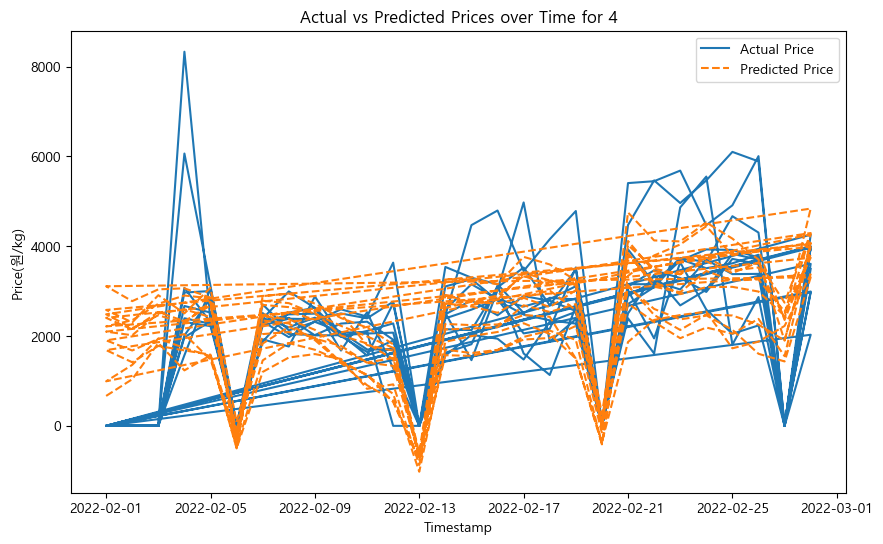

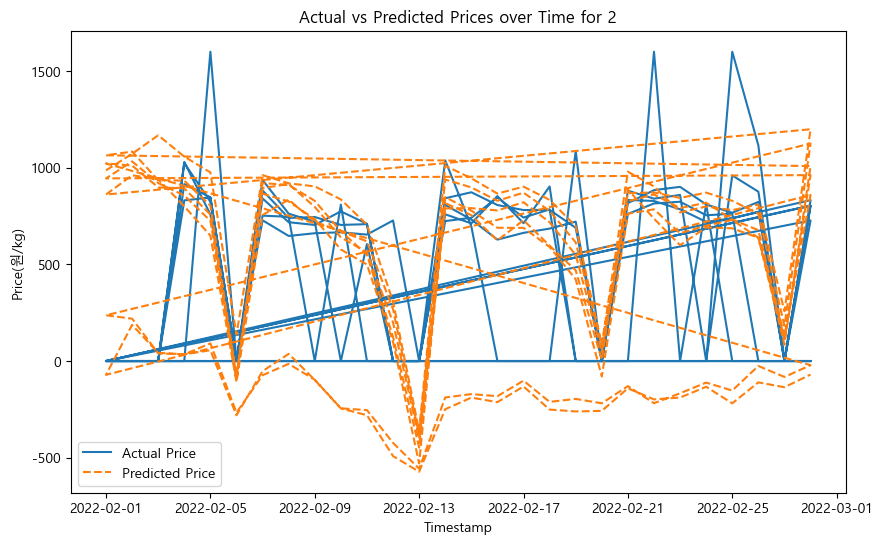

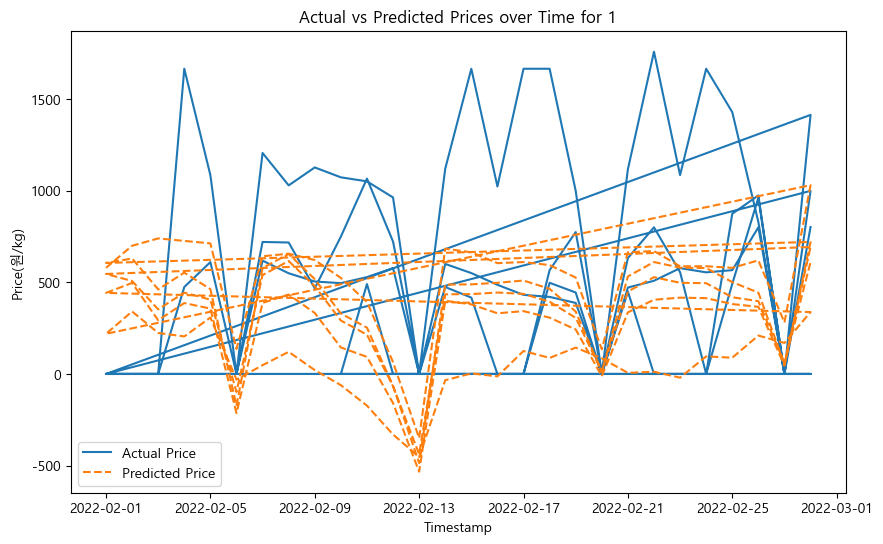

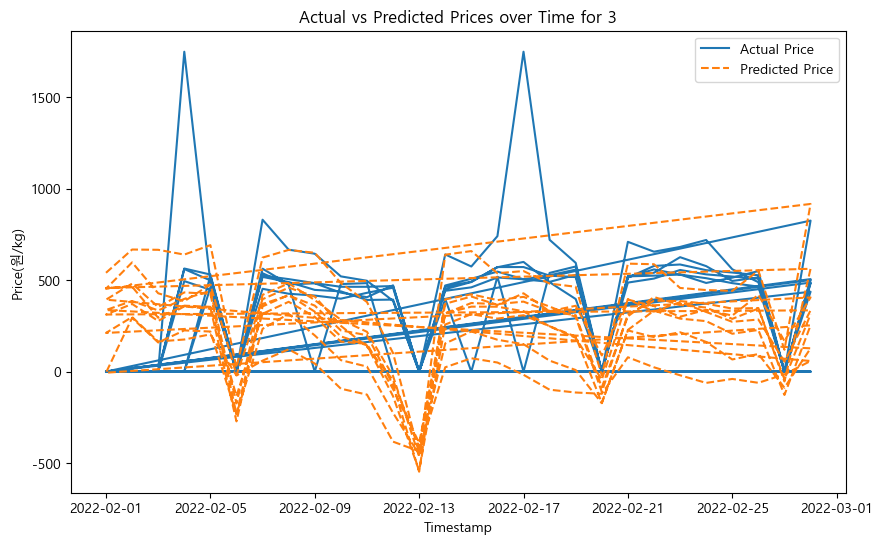

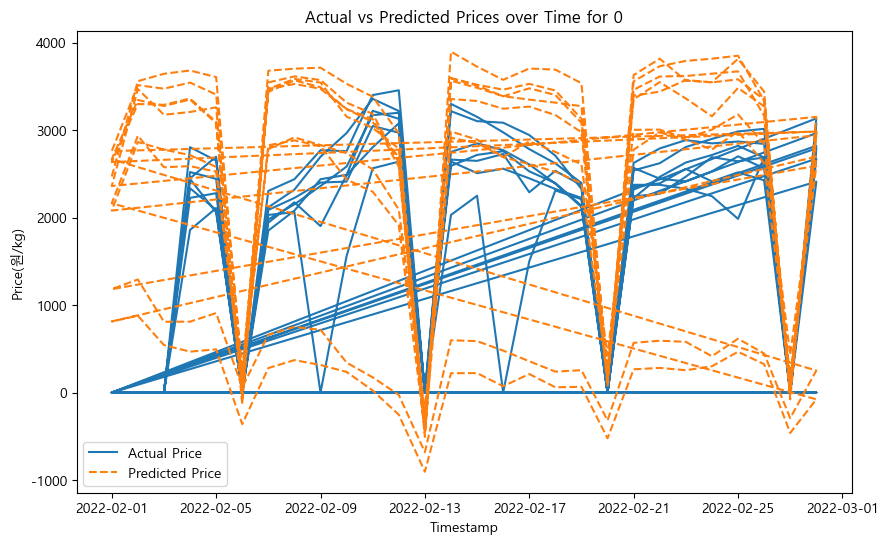

In [116]:
X_new = test_data[['item','corporation','location','year','month','day','dayofweek']]
y_pred_new = model.predict(X_new)
test_data['predicted_price'] = y_pred_new
test_data

# 아이템별로 데이터 분할
items = test_data['item'].unique()

for item in items:
    item_data = test_data[test_data['item'] == item]       # 반복문을 사용해서 items 와 같은 고유값과 test_data의 items가 같은 데이터프레임을 가져온다 (예를들어 items=0 인 값들만 가져옴) 


    plt.figure(figsize=(10, 6))
    plt.plot(item_data['timestamp'], item_data['price(원/kg)'], label='Actual Price')
    plt.plot(item_data['timestamp'], item_data['predicted_price'], label='Predicted Price', linestyle='--')
    plt.xlabel('Timestamp')
    plt.ylabel('Price(원/kg)')
    plt.title(f'Actual vs Predicted Prices over Time for {item}')
    plt.legend()
    plt.show()

